In [3]:
import os
import tensorflow as tf
from glob import glob
import cv2
import numpy as np
import pandas as pd
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Model
import tensorflow.keras.backend as K
from keras.layers import Cropping2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Add, Activation, Lambda
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split

In [4]:
batch_size = 6
lr = 1e-3
epochs = 200
width = 512
height = 512

In [5]:
dataset_path = os.path.join("/kaggle/input/aeroscapes/aeroscapes")
files_dir = os.path.join("files", "modified_uavid_dataset")
model_file = os.path.join(files_dir, "UnetModel.keras")
log_file = os.path.join(files_dir, "Log-Unet.csv")

# Function to create directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
create_dir(files_dir)

In [6]:
def load_data(path):
    Images = sorted(glob(os.path.join(path, "JPEGImages", "*")))
    Labels = sorted(glob(os.path.join(path, "Visualizations", "*")))

    return (Images, Labels)

In [7]:
(Images, Labels) = load_data(dataset_path)

print(f"New Train: {len(Images)} - {len(Labels)}")

# First, split off 10% of the data for testing
train_val_images, test_x, train_val_labels, test_y = train_test_split(Images, Labels, test_size=0.1, random_state=42)

# Then, split the remaining 90% into 70% training and 20% validation (0.7 / 0.9 ≈ 0.78)
train_x, valid_x, train_y, valid_y = train_test_split(train_val_images, train_val_labels, test_size=0.22, random_state=42)

print(f"Training set: {len(train_x)} images")
print(f"Validation set: {len(valid_x)} images")
print(f"Test set: {len(test_x)} images")

New Train: 3269 - 3269
Training set: 2294 images
Validation set: 648 images
Test set: 327 images


In [8]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [9]:
color_map = {
    (0, 0, 0): 0,            # Background
    (192, 128, 128): 1,      # Person
    (0, 128, 0): 2,          # Bike
    (128, 128, 128): 3,      # Car
    (128, 0, 0): 4,          # Drone
    (0, 0, 128): 5,          # Boat
    (192, 0, 128): 6,        # Animal
    (192, 0, 0): 7,          # Obstacle
    (192, 128, 0): 8,        # Construction
    (0, 64, 0): 9,           # Vegetation
    (128, 128, 0): 10,       # Road
    (0, 128, 128): 11,       # Sky
}

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path)  
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) 
    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)

    class_indices = np.zeros((height, width), dtype=np.uint8)

    for rgb, idx in color_map.items():
        class_indices[(mask == rgb).all(axis=-1)] = idx

    return class_indices.astype(np.uint8) 

In [10]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x) 
        y = read_mask(y) 
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.uint8]) 
    x.set_shape([height, width, 3]) 
    y.set_shape([height, width])   
    return x, y

In [11]:
def tf_dataset(x, y, batch=6):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [12]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

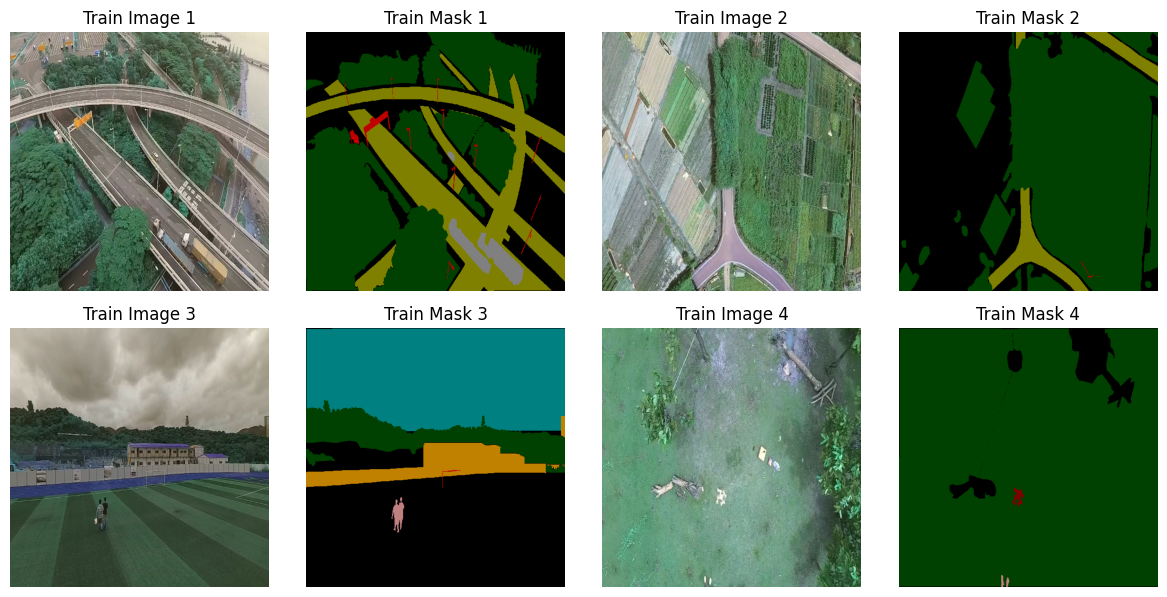

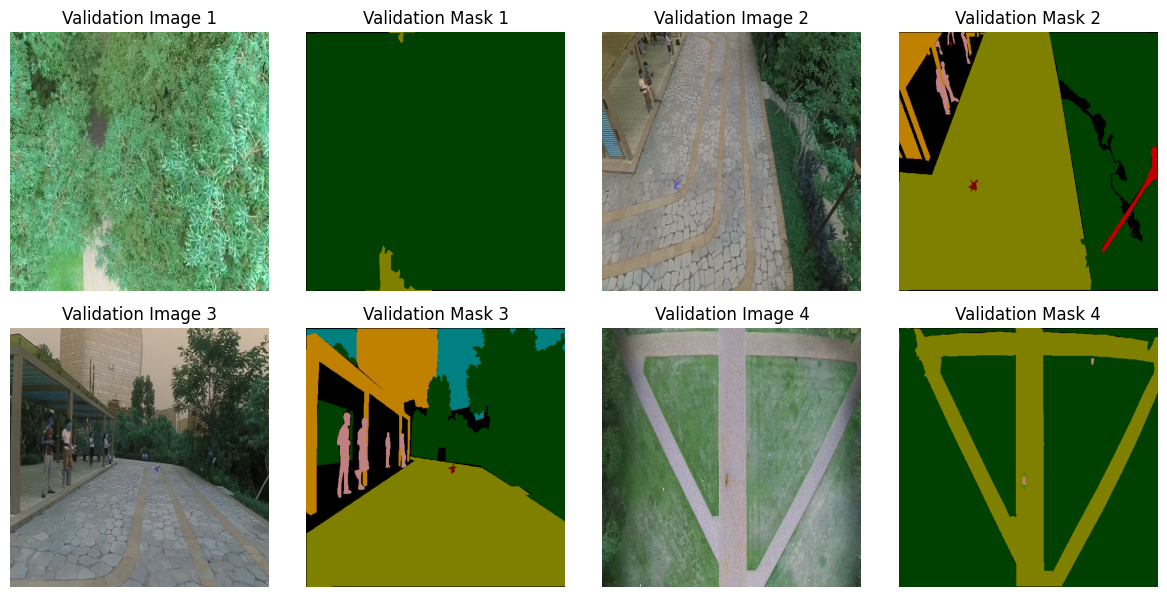

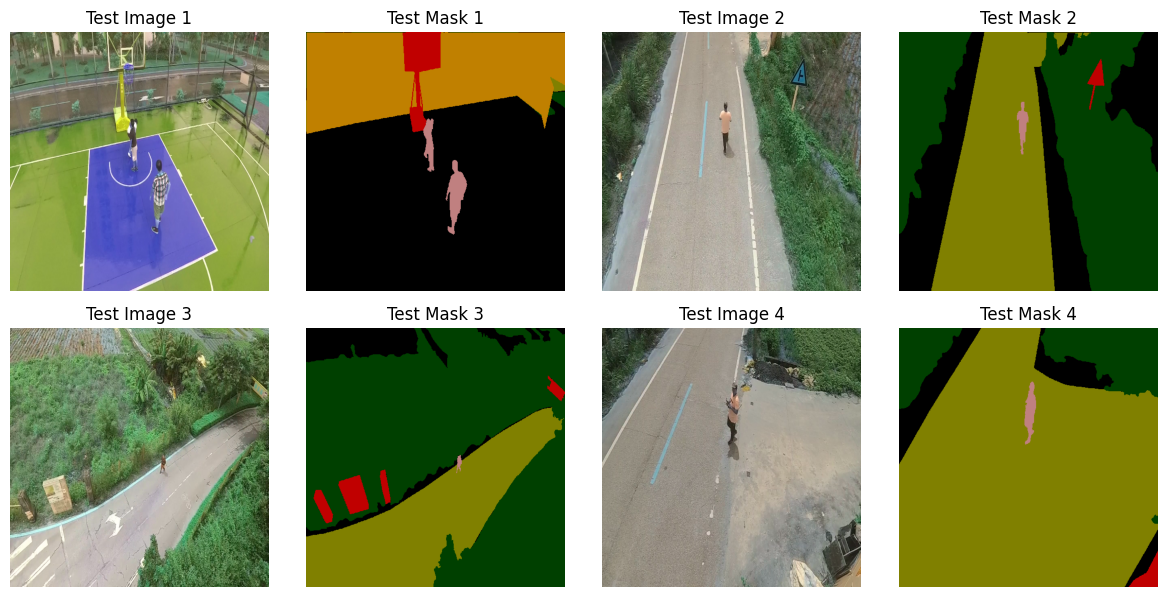

In [13]:
# Create a custom color map based on the color_map dictionary
color_map_values = list(color_map.keys())
color_map_rgb = np.array(color_map_values) / 255.0  # Normalize to 0-1 range for matplotlib

def plot_samples_with_labels(dataset, title):
    plt.figure(figsize=(12, 12))
    for i, (images, masks) in enumerate(dataset.take(1)):  # Take a single batch
        for j in range(4):  # Loop over first four images
            # Plot the image
            plt.subplot(4, 4, j*2 + 1)
            plt.imshow(images[j])
            plt.axis("off")
            plt.title(f"{['Train', 'Validation', 'Test'][title]} Image {j+1}")

            # Convert class indices in the mask to RGB colors
            mask_rgb = np.zeros((height, width, 3), dtype=np.float32)
            for idx, color in enumerate(color_map_rgb):
                mask_rgb[masks[j] == idx] = color

            # Plot the label mask
            plt.subplot(4, 4, j*2 + 2)
            plt.imshow(mask_rgb)
            plt.axis("off")
            plt.title(f"{['Train', 'Validation', 'Test'][title]} Mask {j+1}")
    
    plt.tight_layout()
    plt.show()

# Plot the images and corresponding label masks for each dataset
plot_samples_with_labels(train_dataset, title=0)   # Train images and masks
plot_samples_with_labels(valid_dataset, title=1)   # Validation images and masks
plot_samples_with_labels(test_dataset, title=2)    # Test images and masks

In [14]:
@tf.keras.utils.register_keras_serializable(package='Custom', name='SelfAttention')

class SelfAttention(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)  # Accept additional arguments like 'trainable'
        self.query_dense = layers.Conv2D(embed_dim, kernel_size=1)
        self.key_dense = layers.Conv2D(embed_dim, kernel_size=1)
        self.value_dense = layers.Conv2D(embed_dim, kernel_size=1)
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        channels = inputs.shape[-1]  # Keep channels as a static dimension to avoid shape issues

        # Compute Q, K, V matrices
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Reshape for attention calculation
        query_flattened = tf.reshape(query, (batch_size, height * width, -1))
        key_flattened = tf.reshape(key, (batch_size, height * width, -1))
        value_flattened = tf.reshape(value, (batch_size, height * width, -1))

        # Attention Scores (scaled dot-product): Q * K^T / sqrt(d_k)
        score = tf.matmul(query_flattened, key_flattened, transpose_b=True)
        score = score / tf.math.sqrt(tf.cast(tf.shape(key_flattened)[-1], tf.float32))

        # Apply softmax to get attention weights
        attention_weights = self.softmax(score)

        # Multiply attention weights with values
        attention_output = tf.matmul(attention_weights, value_flattened)

        # Reshape back to original input shape
        attention_output = tf.reshape(attention_output, (batch_size, height, width, inputs.shape[-1]))
    
        # Combine input with attention output
        output = inputs + attention_output
        return output

In [15]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x) 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [16]:
def encod_block(inputs, num_filters):
    x = conv_block(inputs, num_filters) 
    attention_block = SelfAttention(embed_dim=64)(x) # Apply SAM
    p = MaxPool2D((2, 2))(x)
    return x, p

In [17]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
 
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters) 
    attention_block = SelfAttention(embed_dim=64)(x) # Apply SAM
    
    return x

In [18]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encod_block(inputs, 64)

    s2, p2 = encod_block(p1, 128)

    s3, p3 = encod_block(p2, 256)

    s4, p4 = encod_block(p3, 512)
    

    b1 = conv_block(p4, 1024)
    b1 = conv_block(b1, 1024)
    
    
    d1 = decoder_block(b1, s4, 512)
    
    d2 = decoder_block(d1, s3, 256)
    
    d3 = decoder_block(d2, s2, 128)

    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(12, (2, 2), padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name='UNET')
    return model

In [19]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [20]:
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_10[0][0] 

 Total params: 49,942,924 (190.52 MB)

 Trainable params: 49,927,052 (190.46 MB)

 Non-trainable params: 15,872 (62.00 KB)

In [21]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["sparse_categorical_accuracy"])

In [22]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", mode='auto', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

In [23]:
model = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200


I0000 00:00:1731575323.691320      92 service.cc:145] XLA service 0x7e3c200022e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731575323.691402      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1731575325.281149      92 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731575374.211918      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 0.8928 - sparse_categorical_accuracy: 0.6857

W0000 00:00:1731575612.866539      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - loss: 0.8925 - sparse_categorical_accuracy: 0.6858

W0000 00:00:1731575636.591434      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 1.02505, saving model to files/modified_uavid_dataset/UnetModel.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 364s 786ms/step - loss: 0.8922 - sparse_categorical_accuracy: 0.6859 - val_loss: 1.0251 - val_sparse_categorical_accuracy: 0.6025 - learning_rate: 0.0010
Epoch 2/200
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - loss: 0.6809 - sparse_categorical_accuracy: 0.7448
Epoch 2: val_loss improved from 1.02505 to 0.76795, saving model to files/modified_uavid_dataset/UnetModel.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 279s 728ms/step - loss: 0.6809 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.7679 - val_sparse_categorical_accuracy: 0.7310 - learning_rate: 0.0010
Epoch 3/200
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.7729
Epoch 3: val_loss improved from 0.76795 to 0.64261, saving model to files/modified_uavid_dataset/UnetModel.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 279s 728ms/step - loss: 0.6096 - sparse_categorical_a

In [26]:
save_path = os.path.join("Prediction", "modified_uavid_dataset")
model_file = "/kaggle/working/files/modified_uavid_dataset/UnetModel.keras"
create_dir(save_path)

In [27]:
tf.keras.config.enable_unsafe_deserialization()
custom_objects = {
    "SelfAttention": SelfAttention
}
model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)

Index(['epoch', 'learning_rate', 'loss', 'sparse_categorical_accuracy',
       'val_loss', 'val_sparse_categorical_accuracy'],
      dtype='object')


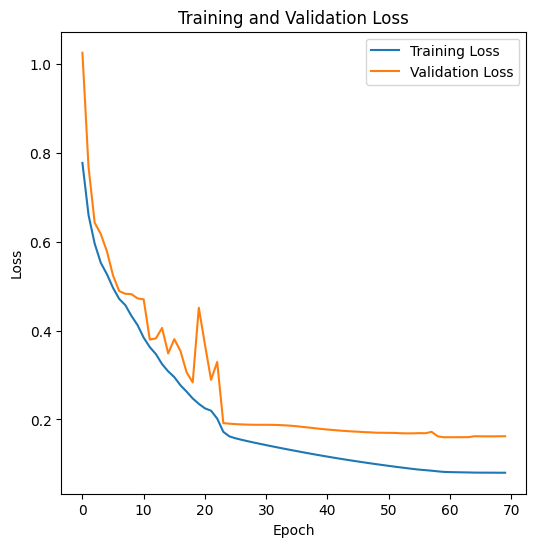

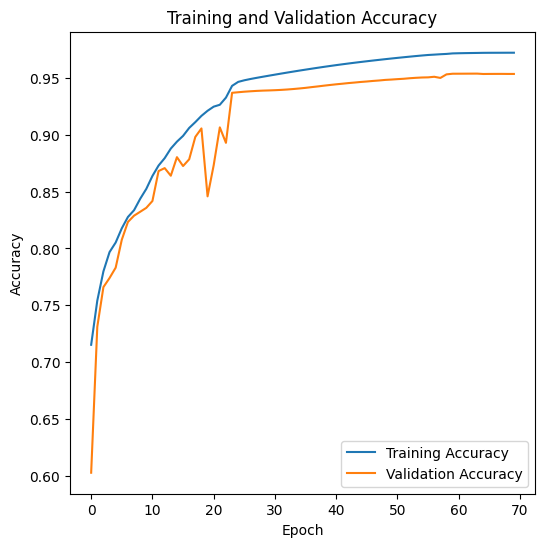

In [28]:
# Load the CSV log file
log_file = os.path.join(files_dir, "Log-Unet.csv")
log_data = pd.read_csv(log_file)
# Check available columns in the CSV
print(log_data.columns)

# Plot Training and Validation Loss
plt.figure(figsize=(6, 6))
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the Loss plot
loss_plot_file_path = os.path.join(files_dir, 'training_validation_loss.png')
plt.savefig(loss_plot_file_path)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 6))
plt.plot(log_data['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(log_data['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Save the Accuracy plot
accuracy_plot_file_path = os.path.join(files_dir, 'training_validation_accuracy.png')
plt.savefig(accuracy_plot_file_path)  # Close the figure to free memory
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


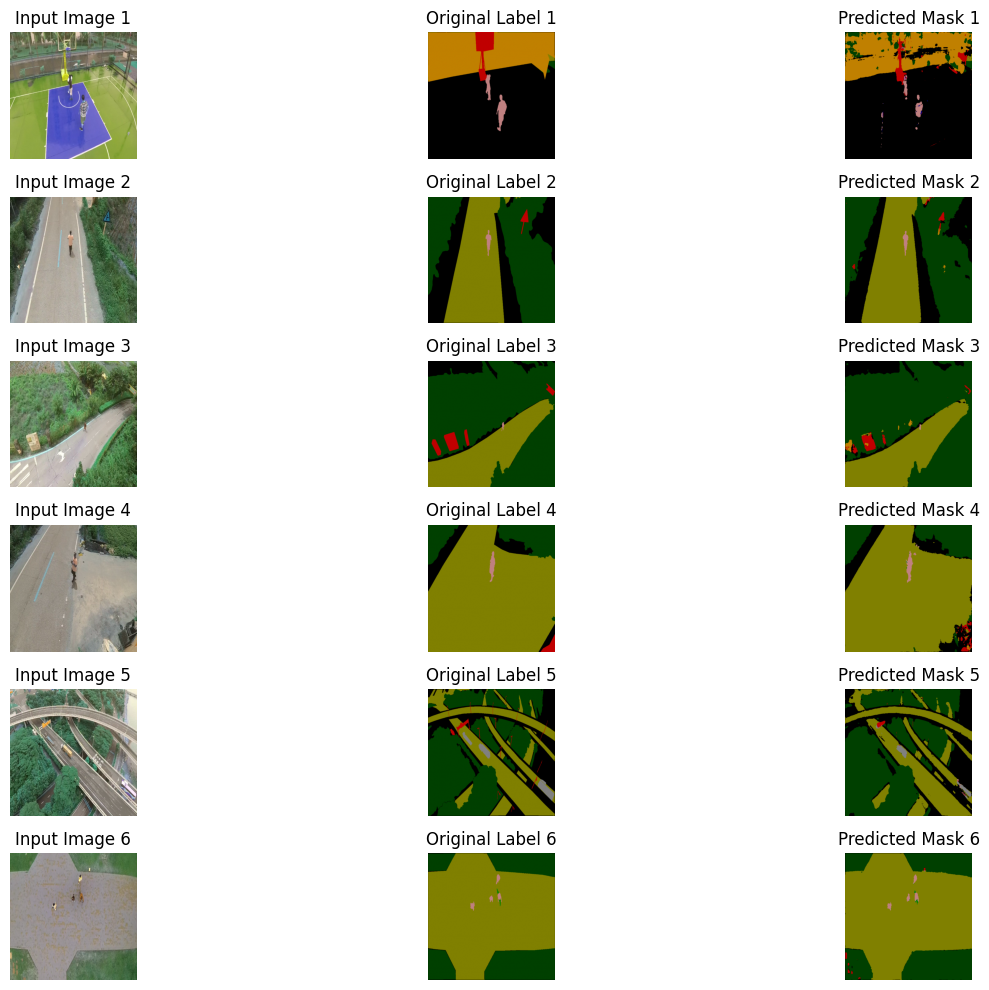

In [29]:
class_to_rgb = {v: k for k, v in color_map.items()}

class_colors = {k: tuple(v/255.0 for v in rgb) for k, rgb in class_to_rgb.items()}
colors = np.array([class_colors[i] for i in sorted(class_colors.keys())])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_colors)+1) - 0.5, ncolors=len(class_colors))

def map_class_to_rgb(class_mask):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for class_index, rgb in class_to_rgb.items():
        rgb_mask[class_mask == class_index] = rgb
    return rgb_mask


plt.figure(figsize=(15, 10))  

batch = next(iter(test_dataset)) 
batch_x, batch_y = batch

num_images = batch_x.shape[0]

for i in range(num_images):

    image = batch_x[i].numpy()
    mask = batch_y[i].numpy()


    prediction = model.predict(np.expand_dims(image, axis=0))[0]  
    predicted_class_indices = np.argmax(prediction, axis=-1) 

    predicted_mask_rgb = map_class_to_rgb(predicted_class_indices)

    original_label_path = test_y[i] 
    original_label = cv2.imread(original_label_path, cv2.IMREAD_COLOR)
    original_label = cv2.cvtColor(original_label, cv2.COLOR_BGR2RGB)
    original_label = cv2.resize(original_label, (width, height)) / 255.0

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(image)
    plt.title(f"Input Image {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(original_label)
    plt.title(f"Original Label {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(predicted_mask_rgb)
    plt.title(f"Predicted Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [30]:
# colors = [
#     (0, 0, 0),           # Background
#     (192, 128, 128),     # Person
#     (0, 128, 0),         # Bike
#     (128, 128, 128),     # Car
#     (128, 0, 0),         # Drone
#     (0, 0, 128),         # Boat
#     (192, 0, 128),       # Animal
#     (192, 0, 0),         # Obstacle
#     (192, 128, 0),       # Construction
#     (0, 64, 0),          # Vegetation
#     (128, 128, 0),       # Road
#     (0, 128, 128),       # Sky
# ]

time_taken = []
for x in tqdm(test_x):
    
    seq_folder = x.split("/")[-3]
    image_name = x.split("/")[-1]
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    start_time = time.time()
    p = model.predict(x)[0] 
    total_time = time.time() - start_time
    time_taken.append(total_time)

    p_class_indices = np.argmax(p, axis=-1)  
    
    p_rgb = np.zeros((p_class_indices.shape[0], p_class_indices.shape[1], 3), dtype=np.uint8)
    
    for rgb, idx in color_map.items():
        p_rgb[p_class_indices == idx] = rgb 
    
    p_rgb = cv2.cvtColor(p_rgb, cv2.COLOR_RGB2BGR)

    save_path_with_name = os.path.join(save_path, f"{seq_folder}_{image_name}")
    cv2.imwrite(save_path_with_name, p_rgb)

  0%|          | 0/327 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 1/327 [00:00<00:48,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 2/327 [00:00<00:45,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 3/327 [00:00<00:44,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 4/327 [00:00<00:43,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 5/327 [00:00<00:43,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 6/327 [00:00<00:43,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 7/327 [00:00<00:43,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 8/327 [00:01<00:42,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 9/327 [00:01<00:41,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 10/327 [00:01<00:41,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 11/327 [00:01<00:40,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▎         | 12/327 [00:01<00:41,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 13/327 [00:01<00:42,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 14/327 [00:01<00:42,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 15/327 [00:02<00:42,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▍         | 16/327 [00:02<00:43,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▌         | 17/327 [00:02<00:43,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 18/327 [00:02<00:45,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 19/327 [00:02<00:43,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 20/327 [00:02<00:43,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▋         | 21/327 [00:02<00:43,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 22/327 [00:03<00:43,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 23/327 [00:03<00:43,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 24/327 [00:03<00:42,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 25/327 [00:03<00:42,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|▊         | 26/327 [00:03<00:41,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 27/327 [00:03<00:41,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▊         | 28/327 [00:03<00:41,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 29/327 [00:03<00:40,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 30/327 [00:04<00:40,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 31/327 [00:04<00:40,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 32/327 [00:04<00:40,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 33/327 [00:04<00:39,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█         | 34/327 [00:04<00:40,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 35/327 [00:04<00:39,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█         | 36/327 [00:04<00:41,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█▏        | 37/327 [00:05<00:41,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 38/327 [00:05<00:40,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 39/327 [00:05<00:40,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 40/327 [00:05<00:39,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 41/327 [00:05<00:39,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 42/327 [00:05<00:39,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 43/327 [00:05<00:38,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 44/327 [00:06<00:38,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 45/327 [00:06<00:38,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 46/327 [00:06<00:38,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 47/327 [00:06<00:38,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 48/327 [00:06<00:37,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 49/327 [00:06<00:37,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▌        | 50/327 [00:06<00:38,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 51/327 [00:07<00:38,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 52/327 [00:07<00:37,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 53/327 [00:07<00:37,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 54/327 [00:07<00:37,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 55/327 [00:07<00:37,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 56/327 [00:07<00:37,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 57/327 [00:07<00:37,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 58/327 [00:07<00:37,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 59/327 [00:08<00:38,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 60/327 [00:08<00:37,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▊        | 61/327 [00:08<00:37,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 62/327 [00:08<00:36,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 63/327 [00:08<00:36,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|█▉        | 64/327 [00:08<00:36,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|█▉        | 65/327 [00:08<00:35,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 66/327 [00:09<00:35,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|██        | 67/327 [00:09<00:35,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██        | 68/327 [00:09<00:35,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 69/327 [00:09<00:35,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██▏       | 70/327 [00:09<00:35,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 71/327 [00:09<00:34,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 72/327 [00:09<00:35,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 73/327 [00:10<00:35,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 74/327 [00:10<00:35,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 75/327 [00:10<00:34,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 76/327 [00:10<00:34,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▎       | 77/327 [00:10<00:34,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 78/327 [00:10<00:34,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 79/327 [00:10<00:34,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 80/327 [00:11<00:34,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▍       | 81/327 [00:11<00:33,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 82/327 [00:11<00:35,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 83/327 [00:11<00:35,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 84/327 [00:11<00:34,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 85/327 [00:11<00:33,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▋       | 86/327 [00:11<00:33,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 87/327 [00:12<00:33,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 88/327 [00:12<00:33,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 89/327 [00:12<00:33,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 90/327 [00:12<00:33,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 91/327 [00:12<00:33,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 92/327 [00:12<00:33,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 93/327 [00:12<00:33,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▊       | 94/327 [00:13<00:32,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 95/327 [00:13<00:32,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 96/327 [00:13<00:32,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 97/327 [00:13<00:33,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 98/327 [00:13<00:33,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 30%|███       | 99/327 [00:13<00:33,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 100/327 [00:13<00:33,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 101/327 [00:14<00:34,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 102/327 [00:14<00:33,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███▏      | 103/327 [00:14<00:32,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 104/327 [00:14<00:32,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 105/327 [00:14<00:32,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 106/327 [00:14<00:31,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 107/327 [00:14<00:30,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 108/327 [00:15<00:30,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 109/327 [00:15<00:30,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▎      | 110/327 [00:15<00:31,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 111/327 [00:15<00:31,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 112/327 [00:15<00:31,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▍      | 113/327 [00:15<00:30,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 114/327 [00:15<00:29,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▌      | 115/327 [00:16<00:29,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 116/327 [00:16<00:29,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 117/327 [00:16<00:28,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 118/327 [00:16<00:28,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 119/327 [00:16<00:28,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 120/327 [00:16<00:27,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 121/327 [00:16<00:28,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 122/327 [00:16<00:28,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 123/327 [00:17<00:28,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 124/327 [00:17<00:27,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 125/327 [00:17<00:30,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▊      | 126/327 [00:17<00:29,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 127/327 [00:17<00:29,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 128/327 [00:17<00:28,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 129/327 [00:18<00:29,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 130/327 [00:18<00:28,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 131/327 [00:18<00:27,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 132/327 [00:18<00:27,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 133/327 [00:18<00:27,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 134/327 [00:18<00:27,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████▏     | 135/327 [00:18<00:26,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 136/327 [00:18<00:26,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 137/327 [00:19<00:27,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 138/327 [00:19<00:26,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 139/327 [00:19<00:25,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 140/327 [00:19<00:25,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 141/327 [00:19<00:25,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 142/327 [00:19<00:25,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▎     | 143/327 [00:19<00:25,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 144/327 [00:20<00:25,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▍     | 145/327 [00:20<00:25,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▍     | 146/327 [00:20<00:25,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▍     | 147/327 [00:20<00:25,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 148/327 [00:20<00:24,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 149/327 [00:20<00:24,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 150/327 [00:20<00:24,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 151/327 [00:21<00:24,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▋     | 152/327 [00:21<00:24,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 153/327 [00:21<00:24,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 154/327 [00:21<00:23,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 155/327 [00:21<00:23,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 156/327 [00:21<00:23,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 157/327 [00:21<00:23,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 158/327 [00:22<00:23,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▊     | 159/327 [00:22<00:23,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 160/327 [00:22<00:23,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 161/327 [00:22<00:23,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 162/327 [00:22<00:23,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 163/327 [00:22<00:23,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 164/327 [00:22<00:23,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 165/327 [00:23<00:22,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 166/327 [00:23<00:22,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 167/327 [00:23<00:21,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████▏    | 168/327 [00:23<00:21,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 169/327 [00:23<00:21,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 170/327 [00:23<00:21,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 171/327 [00:23<00:21,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 172/327 [00:23<00:21,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 173/327 [00:24<00:21,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 174/327 [00:24<00:21,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▎    | 175/327 [00:24<00:20,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 176/327 [00:24<00:20,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 177/327 [00:24<00:20,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 178/327 [00:24<00:20,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 179/327 [00:24<00:20,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 180/327 [00:25<00:20,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 181/327 [00:25<00:20,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▌    | 182/327 [00:25<00:20,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 183/327 [00:25<00:20,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▋    | 184/327 [00:25<00:19,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 185/327 [00:25<00:19,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 186/327 [00:25<00:19,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 187/327 [00:26<00:19,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 188/327 [00:26<00:19,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 189/327 [00:26<00:19,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 190/327 [00:26<00:18,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 191/327 [00:26<00:18,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▊    | 192/327 [00:26<00:19,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 193/327 [00:26<00:19,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 194/327 [00:27<00:18,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|█████▉    | 195/327 [00:27<00:18,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|█████▉    | 196/327 [00:27<00:18,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████    | 197/327 [00:27<00:17,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 198/327 [00:27<00:17,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 199/327 [00:27<00:17,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 200/327 [00:27<00:17,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████▏   | 201/327 [00:28<00:17,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 202/327 [00:28<00:17,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 203/327 [00:28<00:16,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 204/327 [00:28<00:17,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 205/327 [00:28<00:16,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 206/327 [00:28<00:16,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 207/327 [00:28<00:16,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▎   | 208/327 [00:28<00:16,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 209/327 [00:29<00:16,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 210/327 [00:29<00:16,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 211/327 [00:29<00:16,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▍   | 212/327 [00:29<00:16,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▌   | 213/327 [00:29<00:16,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▌   | 214/327 [00:29<00:15,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 215/327 [00:29<00:15,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 216/327 [00:30<00:15,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▋   | 217/327 [00:30<00:15,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 218/327 [00:30<00:15,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 219/327 [00:30<00:15,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 220/327 [00:30<00:14,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 221/327 [00:30<00:14,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 222/327 [00:30<00:14,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 223/327 [00:31<00:14,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▊   | 224/327 [00:31<00:14,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 225/327 [00:31<00:14,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 226/327 [00:31<00:13,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 227/327 [00:31<00:13,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████▉   | 228/327 [00:31<00:13,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████   | 229/327 [00:31<00:13,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 230/327 [00:32<00:14,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 71%|███████   | 231/327 [00:32<00:13,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 232/327 [00:32<00:13,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████▏  | 233/327 [00:32<00:13,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 234/327 [00:32<00:13,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 235/327 [00:32<00:13,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 236/327 [00:32<00:13,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 237/327 [00:33<00:12,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 238/327 [00:33<00:12,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 239/327 [00:33<00:12,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 240/327 [00:33<00:12,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▎  | 241/327 [00:33<00:12,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▍  | 242/327 [00:33<00:11,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 243/327 [00:33<00:11,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▍  | 244/327 [00:34<00:11,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 245/327 [00:34<00:11,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 246/327 [00:34<00:11,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 247/327 [00:34<00:11,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 248/327 [00:34<00:10,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 249/327 [00:34<00:10,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▋  | 250/327 [00:34<00:10,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 251/327 [00:35<00:10,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 252/327 [00:35<00:10,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 253/327 [00:35<00:10,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 254/327 [00:35<00:10,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 255/327 [00:35<00:10,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 256/327 [00:35<00:09,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▊  | 257/327 [00:35<00:09,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 258/327 [00:36<00:09,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 259/327 [00:36<00:09,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|███████▉  | 260/327 [00:36<00:09,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|███████▉  | 261/327 [00:36<00:09,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████  | 262/327 [00:36<00:08,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████  | 263/327 [00:36<00:08,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 264/327 [00:36<00:08,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 265/327 [00:36<00:08,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████▏ | 266/327 [00:37<00:08,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 267/327 [00:37<00:08,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 268/327 [00:37<00:08,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 269/327 [00:37<00:08,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 270/327 [00:37<00:08,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 271/327 [00:37<00:07,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 272/327 [00:37<00:07,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 273/327 [00:38<00:07,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 274/327 [00:38<00:07,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 275/327 [00:38<00:07,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 276/327 [00:38<00:07,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▍ | 277/327 [00:38<00:06,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 278/327 [00:38<00:06,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▌ | 279/327 [00:38<00:06,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 280/327 [00:39<00:06,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 281/327 [00:39<00:06,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 282/327 [00:39<00:06,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 283/327 [00:39<00:06,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 284/327 [00:39<00:05,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 285/327 [00:39<00:05,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 286/327 [00:39<00:05,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 287/327 [00:40<00:05,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 288/327 [00:40<00:05,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 289/327 [00:40<00:05,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▊ | 290/327 [00:40<00:05,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 291/327 [00:40<00:05,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 292/327 [00:40<00:05,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 293/327 [00:40<00:04,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 294/327 [00:41<00:04,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|█████████ | 295/327 [00:41<00:04,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 296/327 [00:41<00:04,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 297/327 [00:41<00:04,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 298/327 [00:41<00:04,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████▏| 299/327 [00:41<00:03,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 300/327 [00:41<00:03,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 301/327 [00:42<00:03,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 302/327 [00:42<00:03,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 303/327 [00:42<00:03,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 304/327 [00:42<00:03,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 305/327 [00:42<00:03,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▎| 306/327 [00:42<00:02,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 307/327 [00:42<00:02,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 308/327 [00:43<00:02,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▍| 309/327 [00:43<00:02,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▍| 310/327 [00:43<00:02,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 311/327 [00:43<00:02,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 312/327 [00:43<00:02,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 313/327 [00:43<00:01,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████▌| 314/327 [00:43<00:01,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▋| 315/327 [00:44<00:01,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 316/327 [00:44<00:01,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 317/327 [00:44<00:01,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 318/327 [00:44<00:01,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 319/327 [00:44<00:01,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 320/327 [00:44<00:01,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 98%|█████████▊| 321/327 [00:44<00:00,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 322/327 [00:45<00:00,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 323/327 [00:45<00:00,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 324/327 [00:45<00:00,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 325/327 [00:45<00:00,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|█████████▉| 326/327 [00:45<00:00,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 327/327 [00:45<00:00,  7.14it/s]


In [31]:
mean_time = np.mean(time_taken)
print(f"Mean time taken: {mean_time}")
mean_fps = 1/mean_time
print(f"Mean FPS: {mean_fps}")

Mean time taken: 0.10042848134988674
Mean FPS: 9.957334677959139


In [32]:
!zip -r SAMunetAEROSCAPES.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'SAMunetAEROSCAPES.zip')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/Prediction/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_040005_034.jpg (deflated 11%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_041009_046.jpg (deflated 11%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_116004_032.jpg (deflated 39%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_000002_079.jpg (deflated 11%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_200002_048.jpg (deflated 16%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_038001_056.jpg (deflated 7%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_200003_018.jpg (deflated 8%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_041001_007.jpg (deflated 12%)
  adding: kaggle/working/Prediction/modifie

/kaggle/working/SAMunetAEROSCAPES.zip